In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 		#to normalize data
from custom_objects import LSTMModel, smape

In [3]:
# Standard scalar normalization
def normalize_data(df, model):
    cols_normalize = df.columns.difference(['id','time_cycles','RUL'])
    norm_df = pd.DataFrame(model.scaler.transform(df[cols_normalize]),
                             columns=cols_normalize,
                             index=df.index)
    join_df = df[df.columns.difference(cols_normalize)].join(norm_df)
    df = join_df.reindex(columns = df.columns)
    return df
        
# Data ETL
def etl(df_path, model, ids):
    index_names = ['id', 'time_cycles']
    setting_names = ['setting_1', 'setting_2', 'setting_3']
    sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
    col_names = index_names + setting_names + sensor_names
        
    try:
        df = pd.read_csv(df_path,sep='\s+',header=None,index_col=False,names=col_names)
    except:
        print("No file was found or it's structure is not as expected")
        
    df = df[df['id'].isin(ids)]
    df = df.sort_values(['id','time_cycles'])
    
    # drop the constants features and the settings based on the EDA
    list_columns_droped = ['setting_1', 'setting_2', 'setting_3', 's_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']
    df.drop(columns=list_columns_droped, inplace=True)
        
    # data normalization
    # it needs to use the saved model
    df = normalize_data(df, model)
        
    print("ETL completed!")
    return df
    
# Production real RUL
def pred_RUL(df, ids):
    y_true = pd.read_csv('../dataset/CMaps/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    idx = [x - 1 for x in ids]
    y_true = y_true['RUL'].iloc[idx].tolist()
    
    m = df.groupby('id')['time_cycles'].max()
    r = [x + y for x, y in zip(m.tolist(), y_true)]

    rul = pd.DataFrame({'id': ids,'max': r,}).reset_index(drop=True)
    df = df.merge(rul, on=['id'], how='left')
    df['RUL'] = df['max'] - df['time_cycles']
    df.drop('max', axis=1, inplace=True)
    return df

In [8]:
model_path = '../trained_models/lstm_pipeline_w5_v2_2024-06-06_13_53_12.pkl'
test_path  = '../dataset/CMaps/test_FD001.txt'

with open(model_path, 'rb') as file:
    lstm_model = pickle.load(file)

ids = [31, 34, 35, 36, 66, 68, 76, 81, 82, 100]

df_test = etl(test_path, lstm_model, ids)
df_test  = pred_RUL(df_test, ids)

x_test =np.concatenate(list(list(lstm_model.get_window(df_test[df_test['id']==unit], lstm_model.window, lstm_model.features)) 
                            for unit in df_test['id'].unique()))
y_test =np.concatenate(list(list(lstm_model.gen_target(df_test[df_test['id']==unit], lstm_model.window, "RUL")) 
                            for unit in df_test['id'].unique()))
y_pred = lstm_model.model.predict(x_test, verbose=0)

2024-06-06 14:00:29.333561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-06 14:00:29.335829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-06 14:00:29.336918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

ETL completed!


2024-06-06 14:00:29.891111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-06 14:00:29.892225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-06 14:00:29.893604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

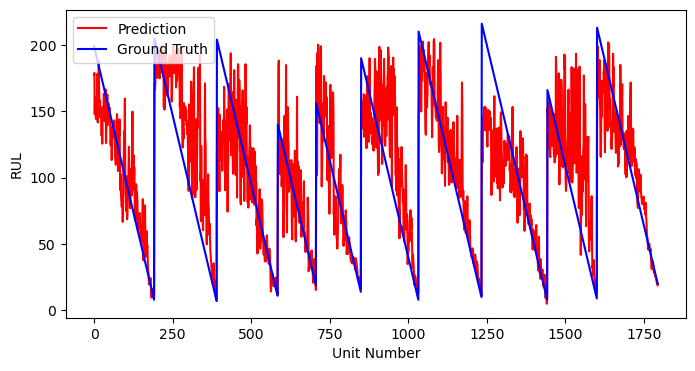

In [9]:
plt.figure(figsize=(8,4))
plt.plot(y_pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

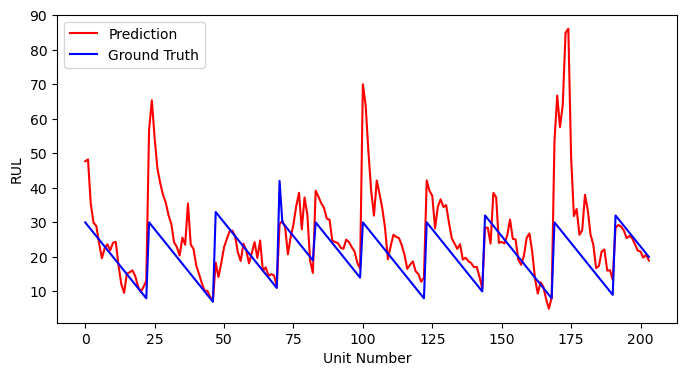

In [10]:
inputs = (y_pred.reshape((-1,)) <= 30, y_test <= 30)
idx = np.any(inputs, axis=0)
y_pred = y_pred[idx]
y_true = y_test[idx]

plt.figure(figsize=(8,4))
plt.plot(y_pred, color='red', label='Prediction')
plt.plot(y_true, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()